### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/21_mediation/alabama-vv-mediation/2023_10_13_16_37_35/count_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/21_mediation/alabama-vv-mediation/2023_10_13_16_37_35/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,Female,2021,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0.0
1,1,Female,2021,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0.0
2,2,Female,2021,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0.0
3,3,Female,2021,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0.0
4,4,Female,2021,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0.0


In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

110497166.13826145

### Total DALYs by Year

In [6]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,Female,25_to_29,29,2021,1971.023009,35.783259,2006.806268
1,Female,25_to_29,29,2022,1859.396284,33.272336,1892.668620
2,Female,25_to_29,29,2023,1852.234213,34.139952,1886.374165
3,Female,25_to_29,29,2024,1911.806920,37.743588,1949.550507
4,Female,25_to_29,29,2025,1552.726275,39.721138,1592.447413


In [7]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2021,6447.513823,776.575448,13959.268235
1,2022,6048.702096,749.112525,12868.466883
2,2023,6144.237133,851.953840,13076.575109
3,2024,6199.623832,819.434351,13639.902872
4,2025,6200.136957,850.593648,13373.236321


### All Cause Mortality Graphs

In [8]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,3.4000,0.0,15.075
1,25_to_29,Female,2022,3.4000,0.0,18.000
2,25_to_29,Female,2023,3.6500,0.0,17.075
3,25_to_29,Female,2024,3.4750,0.0,15.075
4,25_to_29,Female,2025,3.1875,0.0,14.000


#### All Cause Mortality Graph with Rate

In [9]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2021,29,29561.943874
1,25_to_29,Female,2021,232,29333.190965
2,25_to_29,Female,2021,357,29487.890486
3,25_to_29,Female,2021,394,29370.907598
4,25_to_29,Female,2021,602,29263.277207


In [10]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000928,0.000518,0.001275
1,25_to_29,Female,2022,0.001005,0.000487,0.001262
2,25_to_29,Female,2023,0.001087,0.000772,0.001520
3,25_to_29,Female,2024,0.001047,0.000836,0.001351
4,25_to_29,Female,2025,0.000968,0.000583,0.001213


### Cause Specific Mortality Graphs
#### Acute Stroke

In [11]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,Female,2021,acute_ischemic_stroke,0.0,0.0,0.000
1,8,25_to_29,Female,2022,acute_ischemic_stroke,0.0,0.0,0.000
2,16,25_to_29,Female,2023,acute_ischemic_stroke,0.0,0.0,0.000
3,24,25_to_29,Female,2024,acute_ischemic_stroke,0.1,0.0,0.775
4,32,25_to_29,Female,2025,acute_ischemic_stroke,0.1,0.0,0.775


In [12]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,Female,2021,29,acute_ischemic_stroke,0.0
1,8,25_to_29,Female,2021,232,acute_ischemic_stroke,0.0
2,16,25_to_29,Female,2021,357,acute_ischemic_stroke,0.0
3,24,25_to_29,Female,2021,394,acute_ischemic_stroke,0.0
4,32,25_to_29,Female,2021,602,acute_ischemic_stroke,0.0


In [13]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000000,0.0,0.000000
1,25_to_29,Female,2022,0.000000,0.0,0.000000
2,25_to_29,Female,2023,0.000000,0.0,0.000000
3,25_to_29,Female,2024,0.000004,0.0,0.000030
4,25_to_29,Female,2025,0.000004,0.0,0.000029


#### Chronic Stroke

In [14]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000000,0.000000,0.000000
1,25_to_29,Female,2022,0.000000,0.000000,0.000000
2,25_to_29,Female,2023,0.000000,0.000000,0.000000
3,25_to_29,Female,2024,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
596,95_plus,Male,2037,0.007162,0.002387,0.012708
597,95_plus,Male,2038,0.010785,0.007094,0.014957
598,95_plus,Male,2039,0.006717,0.003274,0.012000
599,95_plus,Male,2040,0.008138,0.002481,0.017865


#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [15]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000048,0.0,0.000226
1,25_to_29,Female,2022,0.000046,0.0,0.000203
2,25_to_29,Female,2023,0.000041,0.0,0.000205
3,25_to_29,Female,2024,0.000039,0.0,0.000152
4,25_to_29,Female,2025,0.000040,0.0,0.000172


#### Post Myocaridal Infarction

In [16]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000068,0.000034,0.000128
1,25_to_29,Female,2022,0.000085,0.000008,0.000213
2,25_to_29,Female,2023,0.000130,0.000074,0.000251
3,25_to_29,Female,2024,0.000121,0.000046,0.000250
4,25_to_29,Female,2025,0.000141,0.000000,0.000325


#### Heart Failure

In [17]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000193,0.0,0.000569
1,25_to_29,Female,2022,0.000201,0.0,0.000571
2,25_to_29,Female,2023,0.000225,0.0,0.000641
3,25_to_29,Female,2024,0.000226,0.0,0.000699
4,25_to_29,Female,2025,0.000180,0.0,0.000496


### Excess Mortality rate

#### Post Myocardial Infarction

In [18]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.052578,0.022882,0.096429
1,25_to_29,Female,2022,0.054166,0.003982,0.143565
2,25_to_29,Female,2023,0.074348,0.025758,0.152324
3,25_to_29,Female,2024,0.051944,0.026779,0.080668
4,25_to_29,Female,2025,0.043970,0.000000,0.076496


#### Heart Failure EMR

In [19]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.443978,0.0,2.305593
1,25_to_29,Female,2022,0.428996,0.0,2.060788
2,25_to_29,Female,2023,0.493239,0.0,2.152945
3,25_to_29,Female,2024,0.504414,0.0,2.431716
4,25_to_29,Female,2025,0.490619,0.0,2.120000


### Prevalence 

#### Chronic + Acute Stroke

In [20]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000011,0.000000e+00,0.000037
1,25_to_29,Female,2022,0.000011,6.344766e-07,0.000025
2,25_to_29,Female,2023,0.000009,0.000000e+00,0.000026
3,25_to_29,Female,2024,0.000008,0.000000e+00,0.000024
4,25_to_29,Female,2025,0.000010,0.000000e+00,0.000029


In [21]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [22]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000035,0.000012,0.000070
1,25_to_29,Female,2022,0.000040,0.000015,0.000075
2,25_to_29,Female,2023,0.000038,0.000017,0.000066
3,25_to_29,Female,2024,0.000035,0.000015,0.000063
4,25_to_29,Female,2025,0.000038,0.000014,0.000063


In [23]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.001308,0.000946,0.001513
1,25_to_29,Female,2022,0.001603,0.001210,0.002038
2,25_to_29,Female,2023,0.001936,0.001290,0.002921
3,25_to_29,Female,2024,0.002342,0.001156,0.004214
4,25_to_29,Female,2025,0.002894,0.001033,0.005940


In [24]:
tran = pd.read_csv(sim_results_dir + '/transition_count.csv')
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ#.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2021  0.000000  0.000000  0.000000
                2022  0.000000  0.000000  0.000000
                2023  0.000000  0.000000  0.000000
                2024  0.000000  0.000000  0.000000
...                        ...       ...       ...
95_plus  Male   2037  0.158400  0.083154  0.218770
                2038  0.194168  0.109110  0.251592
                2039  0.151905  0.102717  0.272690
                2040  0.140262  0.065871  0.244802

[600 rows x 3 columns]

In [25]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 Female 2021   1.0   1.0    1.0
                2022   1.0   1.0    1.0
                2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0

### Prevalence of Heart Failure

In [26]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.001281,0.000106,0.002957
1,25_to_29,Female,2022,0.001261,0.000160,0.002999
2,25_to_29,Female,2023,0.001276,0.000163,0.002944
3,25_to_29,Female,2024,0.001269,0.000158,0.003142
4,25_to_29,Female,2025,0.001225,0.000106,0.003047


### Incidence of First Time Acute Ischemic Stroke

In [27]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,10,25_to_29,Female,2021,susceptible_to_ischemic_stroke_to_acute_ischem...,4.1,0.000,14.200
1,21,25_to_29,Female,2022,susceptible_to_ischemic_stroke_to_acute_ischem...,4.5,0.225,9.775
2,32,25_to_29,Female,2023,susceptible_to_ischemic_stroke_to_acute_ischem...,2.8,0.000,8.775
3,43,25_to_29,Female,2024,susceptible_to_ischemic_stroke_to_acute_ischem...,2.4,0.000,8.100
4,54,25_to_29,Female,2025,susceptible_to_ischemic_stroke_to_acute_ischem...,3.5,0.000,10.650


In [28]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,80,25_to_29,Female,2021,susceptible_to_ischemic_stroke,29,29409.390828
1,81,25_to_29,Female,2021,susceptible_to_ischemic_stroke,232,29180.867899
2,82,25_to_29,Female,2021,susceptible_to_ischemic_stroke,357,29321.308693
3,83,25_to_29,Female,2021,susceptible_to_ischemic_stroke,394,29211.225188
4,84,25_to_29,Female,2021,susceptible_to_ischemic_stroke,602,29100.298426


In [29]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.000140,0.000000,0.000481
1,25_to_29,Female,2022,0.000166,0.000008,0.000363
2,25_to_29,Female,2023,0.000104,0.000000,0.000325
3,25_to_29,Female,2024,0.000090,0.000000,0.000305
4,25_to_29,Female,2025,0.000133,0.000000,0.000406


### Incidence of Acute Myocardial Infraction 

In [30]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI_HF = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_MI_HF

,index,Unnamed: 0,sex,year,measure,input_draw,scenario,age,transition,value
0,60,60,Female,2021,transition_count,29,baseline,25_to_29,heart_failure_from_ischemic_heart_disease_to_a...,0.0
1,61,61,Female,2021,transition_count,29,baseline,30_to_34,heart_failure_from_ischemic_heart_disease_to_a...,0.0
2,62,62,Female,2021,transition_count,29,baseline,35_to_39,heart_failure_from_ischemic_heart_disease_to_a...,0.0
3,63,63,Female,2021,transition_count,29,baseline,40_to_44,heart_failure_from_ischemic_heart_disease_to_a...,0.0
...,...,...,...,...,...,...,...,...,...,...
5996,65906,65906,Male,2040,transition_count,946,baseline,80_to_84,heart_failure_from_ischemic_heart_disease_to_a...,15.0
5997,65907,65907,Male,2040,transition_count,946,baseline,85_to_89,heart_failure_from_ischemic_heart_disease_to_a...,19.0
5998,65908,65908,Male,2040,transition_count,946,baseline,90_to_94,heart_failure_from_ischemic_heart_disease_to_a...,12.0
5999,65909,65909,Male,2040,transition_count,946,baseline,95_plus,heart_failure_from_ischemic_heart_disease_to_a...,5.0


In [31]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2021  0.000486  0.000161  0.000994
                2022  0.000529  0.000230  0.000944
                2023  0.000489  0.000157  0.000807
                2024  0.000456  0.000235  0.000801
                2025  0.000487  0.000170  0.000744

### Incidence of Heart Failure 

In [32]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2021  0.000657  0.000509  0.000821
                2022  0.000704  0.000376  0.001084
                2023  0.000698  0.000425  0.000955
                2024  0.000597  0.000260  0.001112
                2025  0.000582  0.000353  0.000762

### Artifacts

In [33]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v3-20231013/

README                    kentucky.hdf        north_dakota.hdf
alabama.hdf               logs/               ohio.hdf
alaska.hdf                louisiana.hdf       oklahoma.hdf
arizona.hdf               maine.hdf           oregon.hdf
arkansas.hdf              maryland.hdf        paf-calculations/
california.hdf            massachusetts.hdf   pennsylvania.hdf
colorado.hdf              michigan.hdf        rhode_island.hdf
connecticut.hdf           minnesota.hdf       south_carolina.hdf
delaware.hdf              mississippi.hdf     south_dakota.hdf
district_of_columbia.hdf  missouri.hdf        tennessee.hdf
florida.hdf               montana.hdf         texas.hdf
georgia.hdf               nebraska.hdf        utah.hdf
hawaii.hdf                nevada.hdf          vermont.hdf
idaho.hdf                 new_hampshire.hdf   virginia.hdf
illinois.hdf              new_jersey.hdf      washington.hdf
indiana.hdf               new_mexico.hdf      west_virginia.hdf
iowa.hdf                  new_york.

In [34]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v3-20231013/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [35]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [36]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [37]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama-vv-mediation.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [38]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [39]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.001089,0.000584,0.001635
1,25_to_29,Male,0.002285,0.001692,0.002981
2,30_to_34,Female,0.001368,0.000889,0.001914
3,30_to_34,Male,0.002460,0.001790,0.003168
4,35_to_39,Female,0.001734,0.001172,0.002359


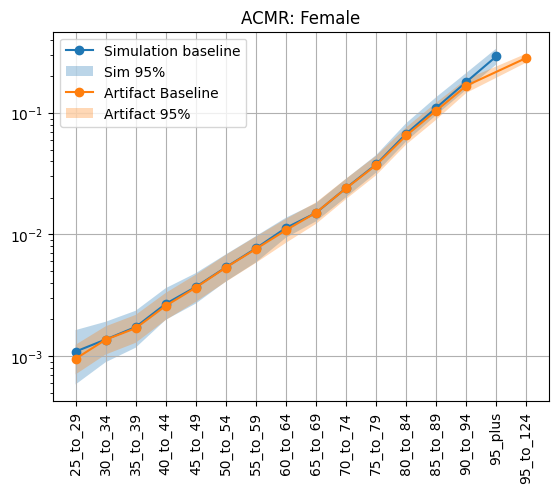

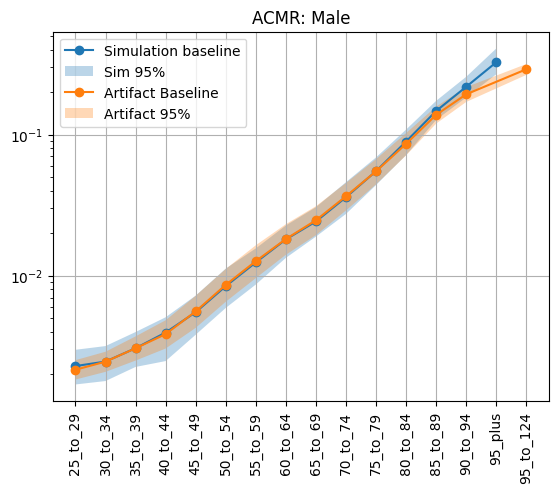

In [40]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'ACMR: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [41]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [42]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [43]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [44]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [45]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000003,0.0,0.000041
1,25_to_29,Male,0.000003,0.0,0.000039
2,30_to_34,Female,0.000003,0.0,0.000039
3,30_to_34,Male,0.000003,0.0,0.000038
4,35_to_39,Female,0.000006,0.0,0.000039


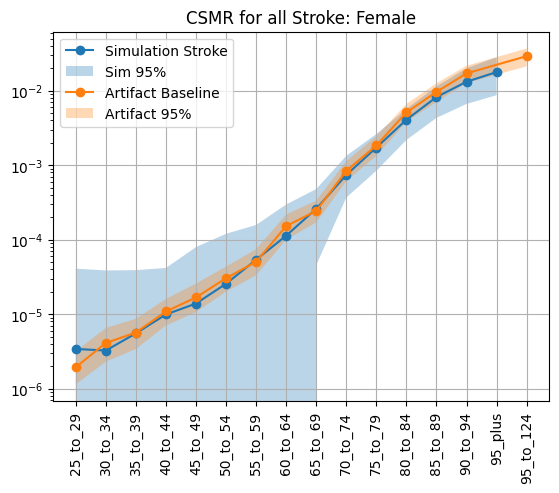

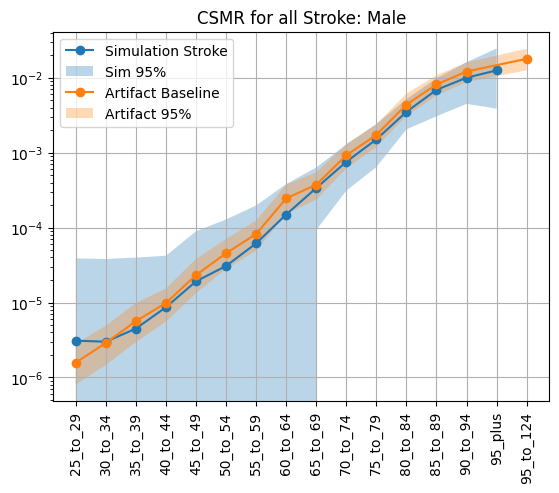

In [46]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
    plt.plot(subdata4['age'], subdata4['mean'], marker='o')
    plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
    subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for all Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.yscale('log')
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [47]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000546,0.000412,0.000710,Alabama,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000652,0.000483,0.000838,Alabama,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000746,0.000545,0.000978,Alabama,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000804,0.000611,0.001051,Alabama,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.001383,0.001112,0.001699,Alabama,cause_specific_mortality_rate,45_to_49


In [48]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000689,0.000253,0.001127
1,25_to_29,Male,0.000927,0.000550,0.001407
2,30_to_34,Female,0.000658,0.000302,0.001033
3,30_to_34,Male,0.001003,0.000563,0.001453
...,...,...,...,...,...
26,90_to_94,Female,0.111290,0.080456,0.138655
27,90_to_94,Male,0.171425,0.130626,0.212288
28,95_plus,Female,0.148500,0.110339,0.195334
29,95_plus,Male,0.232507,0.160859,0.301734


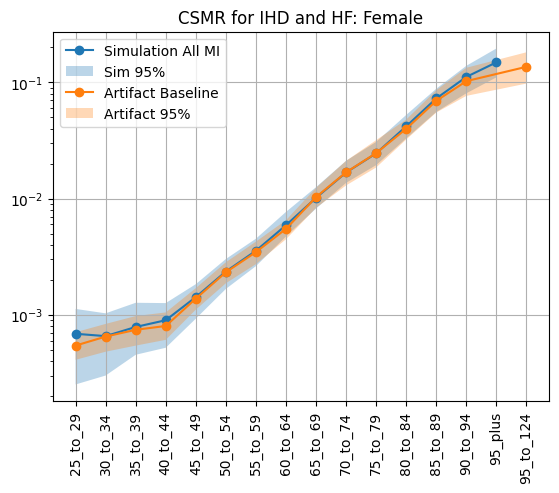

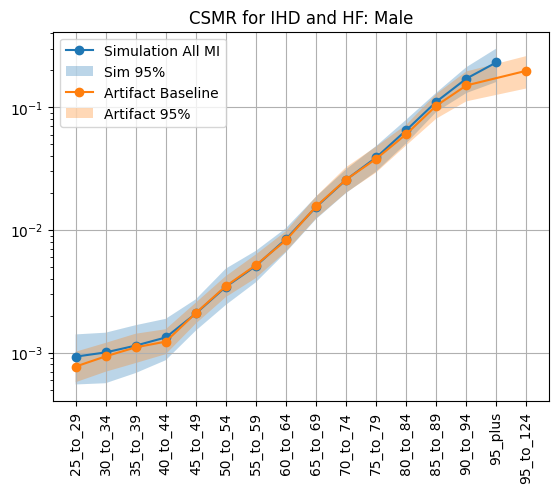

In [49]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [50]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [51]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,50%,2.5%,97.5%
0,25_to_29,Female,0.000077,0.000000,0.000479
1,25_to_29,Male,0.000038,0.000000,0.000304
2,30_to_34,Female,0.000150,0.000000,0.000465
3,30_to_34,Male,0.000076,0.000000,0.000307
4,35_to_39,Female,0.000228,0.000038,0.000548


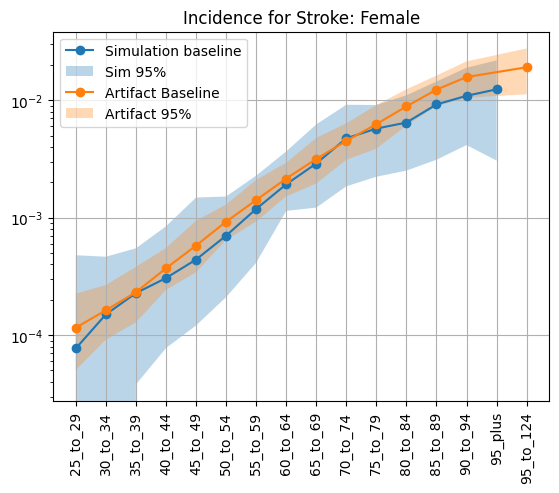

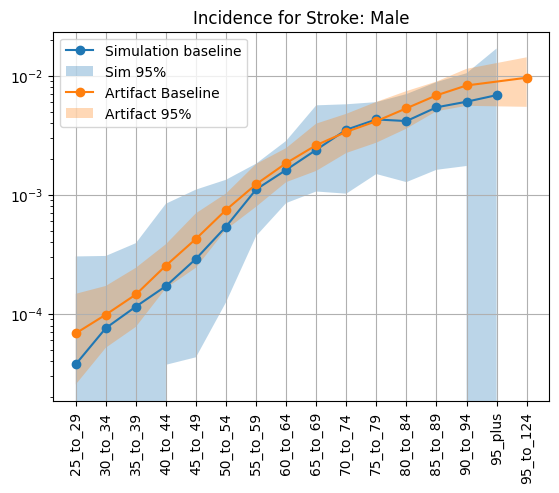

In [52]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [53]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000453,0.000285,0.000617,Alabama,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000512,0.000347,0.000685,Alabama,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000428,0.000297,0.000583,Alabama,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000541,0.000415,0.000692,Alabama,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000853,0.000652,0.001114,Alabama,incidence_rate,45_to_49


In [54]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_HF = tran_rate_MI_HF.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_rate_MI_HF = (tran_rate_MI_HF.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_rate_MI_HF.head()

mean  50%  2.5%     97.5%
age      sex                                      
25_to_29 Female  0.000000e+00  0.0   0.0  0.000000
         Male    0.000000e+00  0.0   0.0  0.000000
30_to_34 Female  0.000000e+00  0.0   0.0  0.000000
         Male    3.830679e-07  0.0   0.0  0.000002
35_to_39 Female  1.913922e-07  0.0   0.0  0.000001

In [55]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 Female  0.000518  0.000485  0.000293  0.000798
         Male    0.000459  0.000398  0.000151  0.000881
30_to_34 Female  0.000523  0.000508  0.000329  0.000853
         Male    0.000680  0.000679  0.000432  0.000924
35_to_39 Female  0.000497  0.000516  0.000368  0.000588

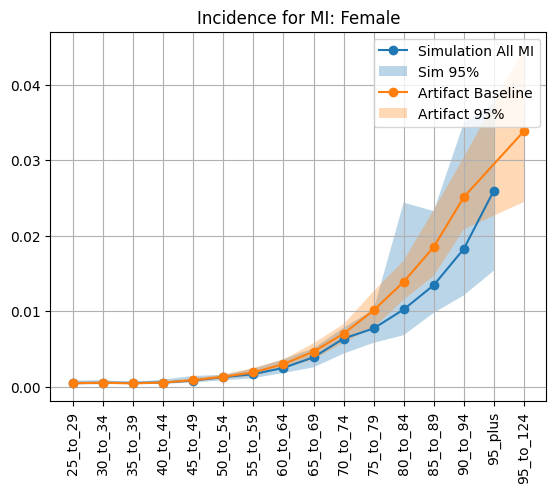

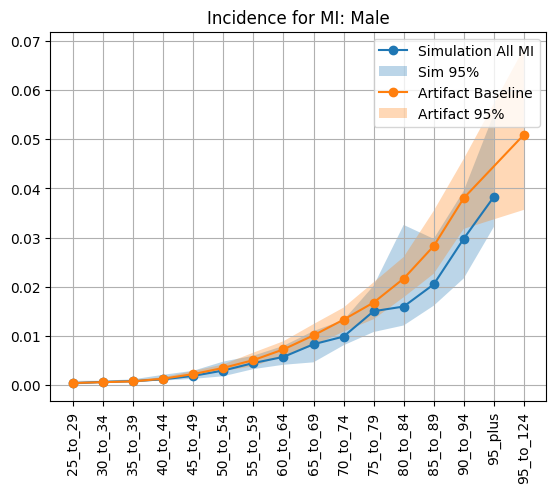

In [56]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    #plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [57]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000057,0.000041,0.000075,Alabama,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000081,0.000060,0.000104,Alabama,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000089,0.000056,0.000130,Alabama,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000185,0.000138,0.000239,Alabama,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000497,0.000408,0.000590,Alabama,incidence_rate,45_to_49


In [58]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000063  0.000026  0.000087
         Male    0.000135  0.000116  0.000154
30_to_34 Female  0.000082  0.000054  0.000115
         Male    0.000181  0.000136  0.000207
35_to_39 Female  0.000093  0.000066  0.000122

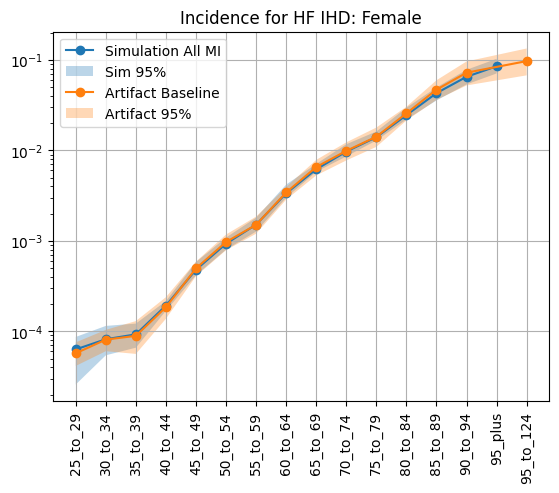

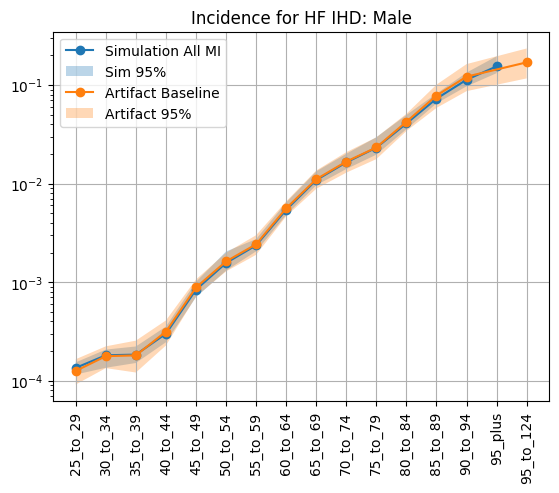

In [59]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [60]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000601,0.000435,0.000792,Alabama,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000568,0.000423,0.000728,Alabama,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000395,0.000249,0.000574,Alabama,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000683,0.000509,0.000880,Alabama,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.001313,0.001078,0.001558,Alabama,incidence_rate,45_to_49


In [61]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000603  0.000469  0.000778
         Male    0.000930  0.000779  0.001217
30_to_34 Female  0.000585  0.000411  0.000746
         Male    0.000822  0.000685  0.000959
35_to_39 Female  0.000421  0.000339  0.000517

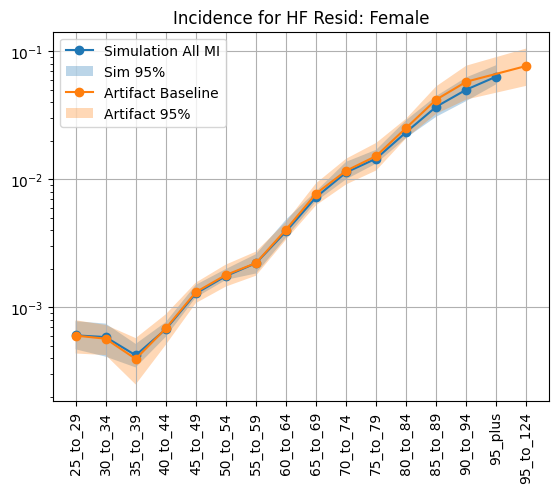

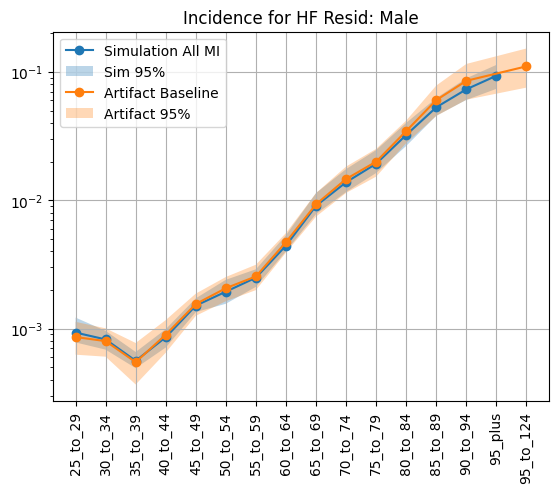

In [62]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [63]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [64]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


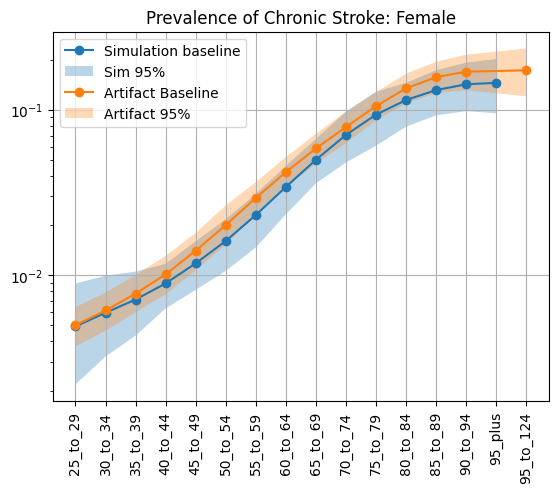

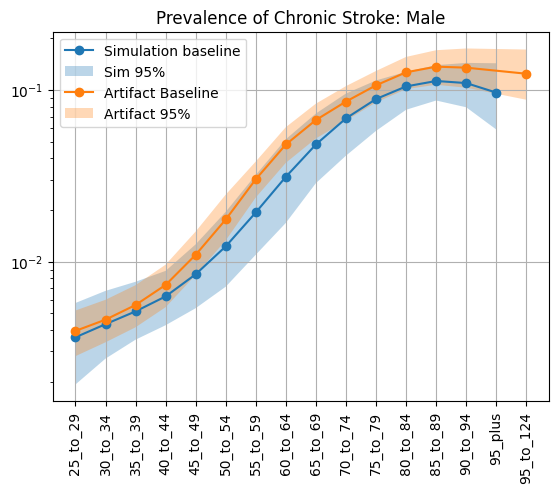

In [65]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [66]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [67]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

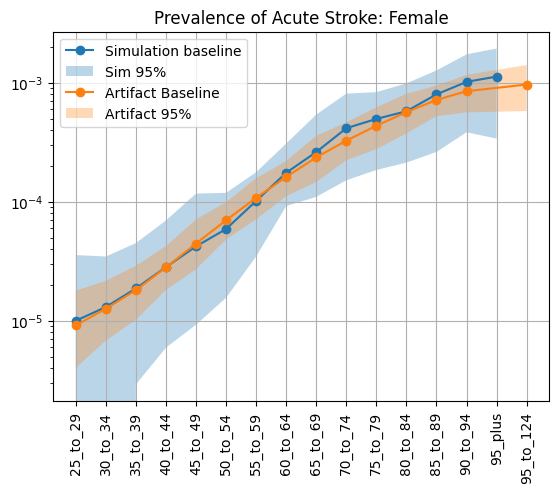

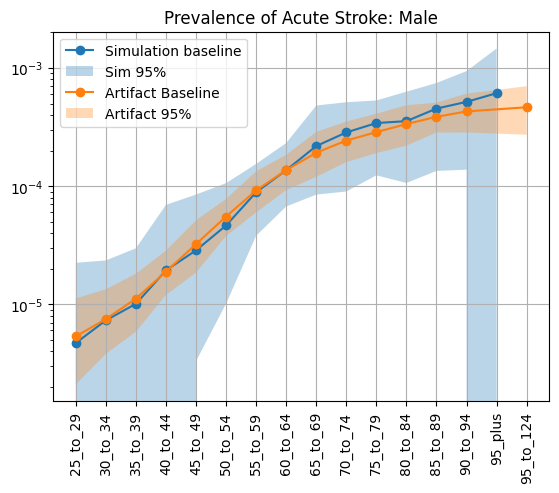

In [68]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [69]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.002535,0.001864,0.003276,Alabama,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.004010,0.003123,0.005006,Alabama,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.005656,0.004445,0.007094,Alabama,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.007601,0.005987,0.009411,Alabama,prevalence,45_to_49


In [70]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,0.001308,0.000946,0.001513
1,25_to_29,Female,2022,0.001603,0.001210,0.002038
2,25_to_29,Female,2023,0.001936,0.001290,0.002921
3,25_to_29,Female,2024,0.002342,0.001156,0.004214
4,25_to_29,Female,2025,0.002894,0.001033,0.005940


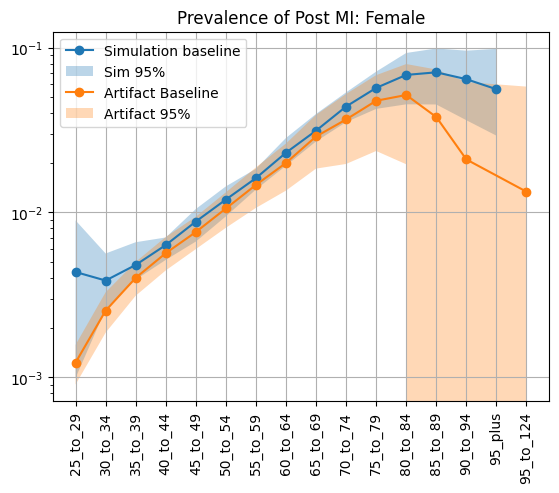

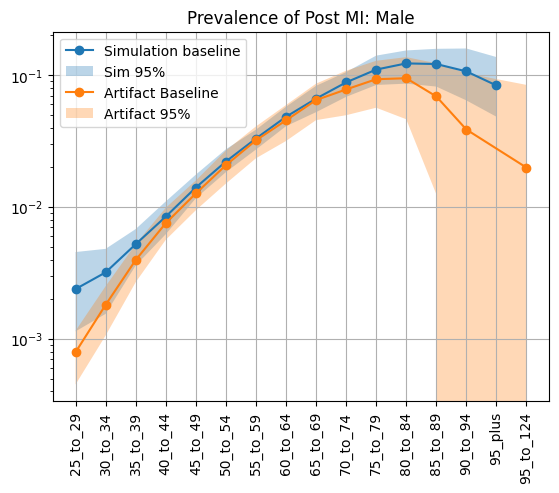

In [71]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [72]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [73]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000031,0.000021,0.000042,Alabama,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [74]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000040,0.000013,0.000076
1,25_to_29,Male,0.000035,0.000006,0.000081
2,30_to_34,Female,0.000040,0.000015,0.000081
3,30_to_34,Male,0.000052,0.000023,0.000083
4,35_to_39,Female,0.000038,0.000018,0.000066


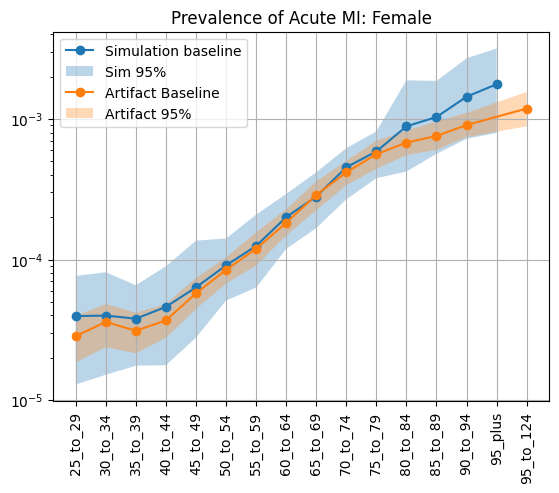

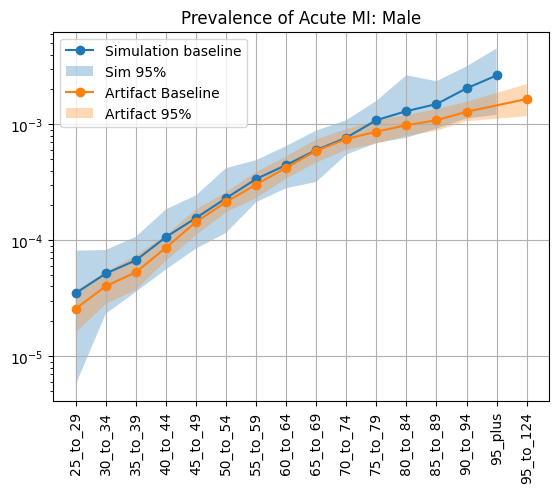

In [75]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [76]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000224,0.000169,0.000288,Alabama,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000471,0.000345,0.000624,Alabama,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000680,0.000515,0.000866,Alabama,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000746,0.000582,0.000948,Alabama,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.001574,0.001337,0.001821,Alabama,prevalence,45_to_49


In [77]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000213,0.000044,0.000426
1,25_to_29,Male,0.000410,0.000201,0.000718
2,30_to_34,Female,0.000388,0.000126,0.000689
3,30_to_34,Male,0.000773,0.000464,0.001159
4,35_to_39,Female,0.000508,0.000217,0.000805


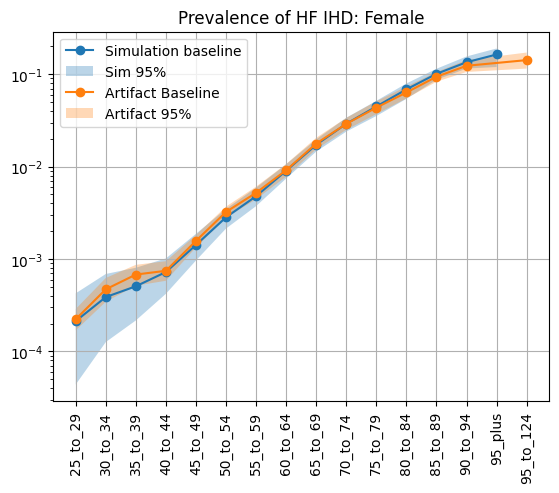

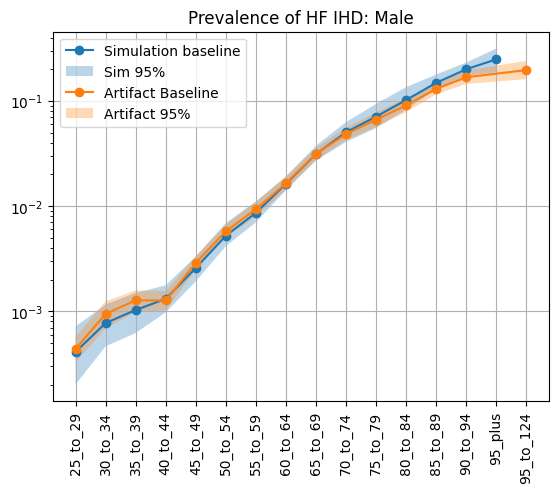

In [78]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [79]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.002341,0.001774,0.003021,Alabama,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.003290,0.002414,0.004362,Alabama,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.002993,0.002267,0.003813,Alabama,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.002735,0.002134,0.003475,Alabama,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.004126,0.003504,0.004772,Alabama,prevalence,45_to_49


In [80]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.002455,0.001688,0.003494
1,25_to_29,Male,0.003238,0.002403,0.003936
2,30_to_34,Female,0.003352,0.002262,0.004913
3,30_to_34,Male,0.004376,0.003495,0.005566
4,35_to_39,Female,0.003376,0.002504,0.004528


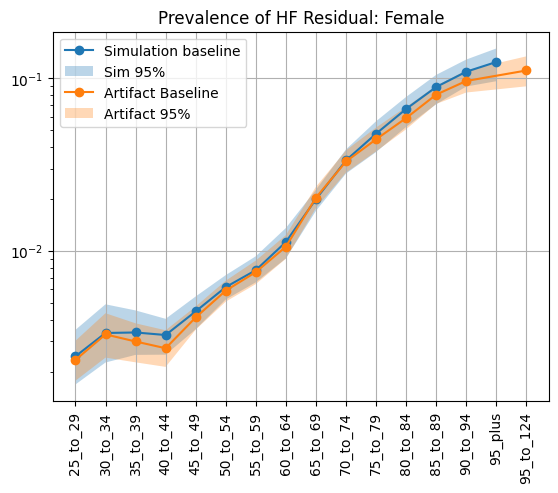

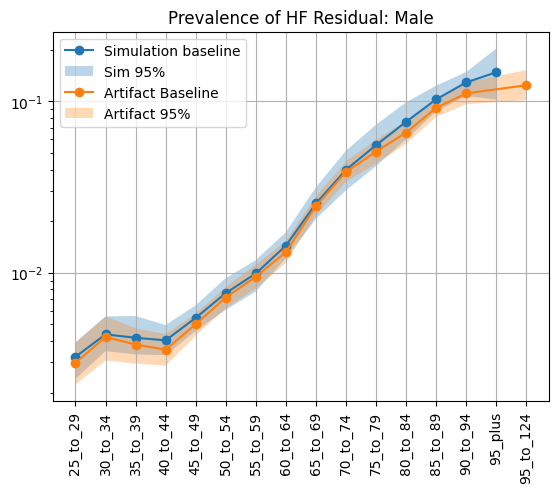

In [81]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [82]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [83]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.316648,0.0,3.261161
1,25_to_29,Male,0.511004,0.0,6.522321
2,30_to_34,Female,0.292158,0.0,4.348214
3,30_to_34,Male,0.403558,0.0,4.348214
4,35_to_39,Female,0.223418,0.0,2.608929


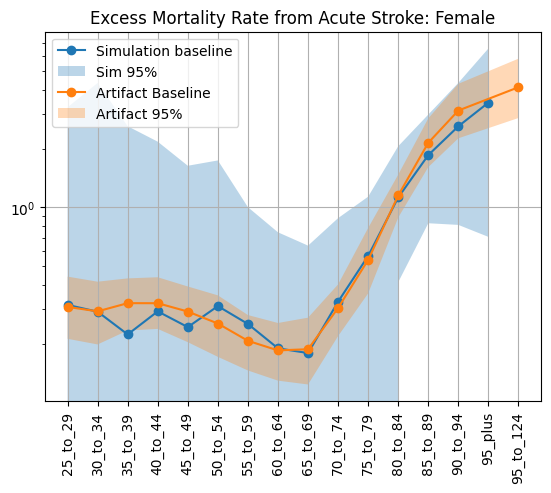

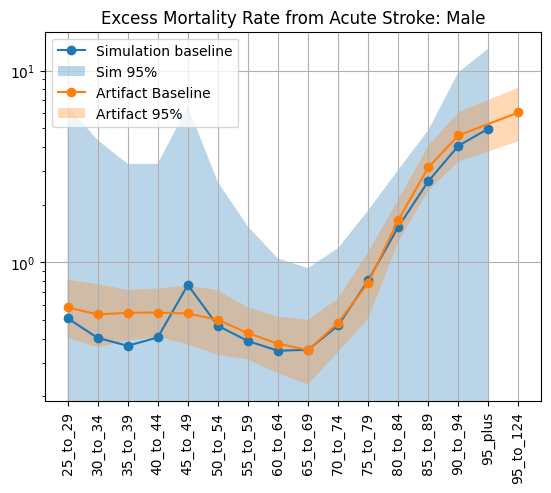

In [84]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [85]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [86]:
chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000025,0.0,0.0
1,25_to_29,Male,0.000000,0.0,0.0
2,30_to_34,Female,0.000039,0.0,0.0
3,30_to_34,Male,0.000000,0.0,0.0
4,35_to_39,Female,0.000082,0.0,0.0


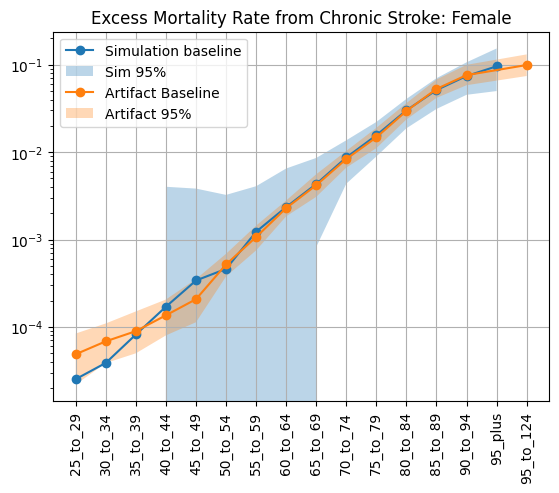

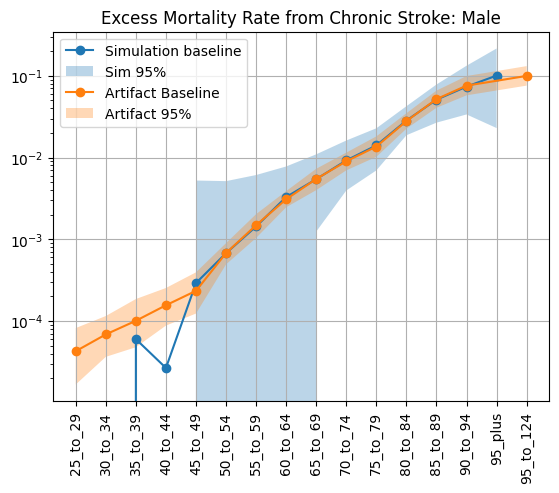

In [87]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [88]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [89]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2021,2.585477,0.000000,4.130027
1,25_to_29,Female,2022,1.881538,0.000000,4.152545
2,25_to_29,Female,2023,1.958767,0.000000,3.541983
3,25_to_29,Female,2024,2.531138,0.255221,5.972001
4,25_to_29,Female,2025,2.091266,0.139764,3.490924


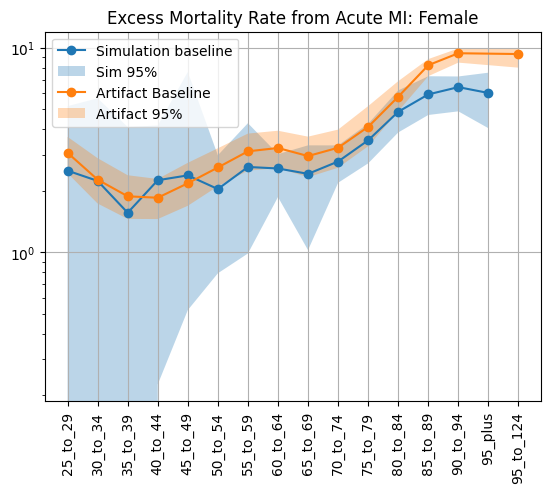

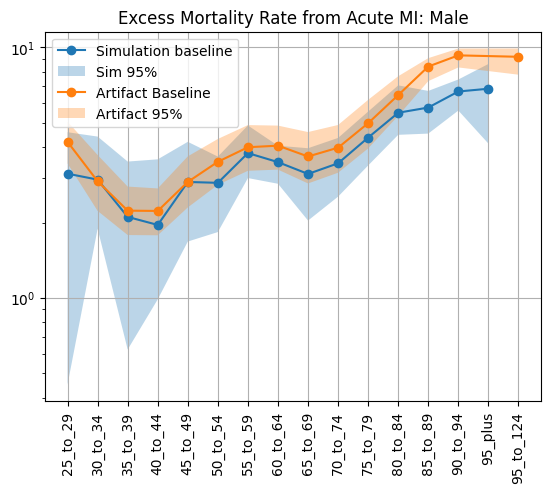

In [90]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [91]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.046535,0.0,0.122661
1,25_to_29,Male,0.053753,0.0,0.135418
2,30_to_34,Female,0.023187,0.0,0.059583
3,30_to_34,Male,0.028158,0.0,0.073570
4,35_to_39,Female,0.016361,0.0,0.039292


In [92]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

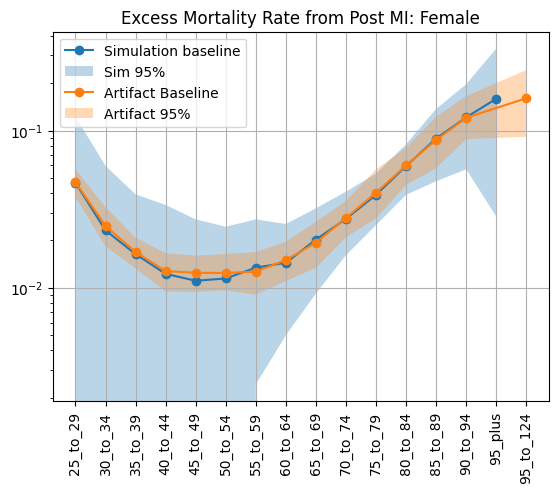

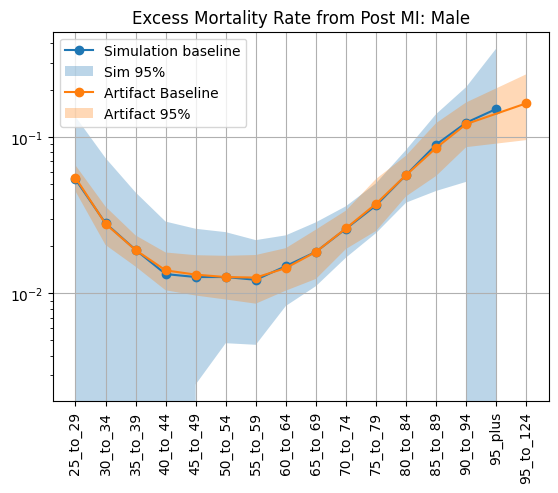

In [93]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### EMR for Heart Failure

In [94]:
art_emr_HF = load_artifact_data('cause', 'heart_failure', 'excess_mortality_rate')
art_emr_HF['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_HF.age_start,art_emr_HF.age_end)]
art_emr_HF.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.157219,0.111406,0.216535,Alabama,excess_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.136440,0.095899,0.187640,Alabama,excess_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.169535,0.122948,0.222670,Alabama,excess_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.192198,0.141037,0.254912,Alabama,excess_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.204429,0.163795,0.255060,Alabama,excess_mortality_rate,45_to_49


In [95]:
HF_emr_allyear = (HF_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025,0.5, .975])
                      .filter(['mean','50%', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_allyear.head()

,age,sex,mean,50%,2.5%,97.5%
0,25_to_29,Female,inf,0.142651,0.0,4.658801
1,25_to_29,Male,0.528043,0.175057,0.0,2.807237
2,30_to_34,Female,0.417910,0.120602,0.0,2.504653
3,30_to_34,Male,0.307869,0.146057,0.0,1.353706
4,35_to_39,Female,0.395889,0.162781,0.0,1.831644


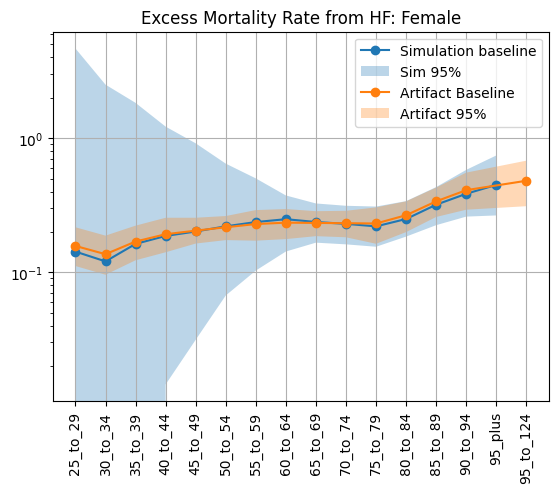

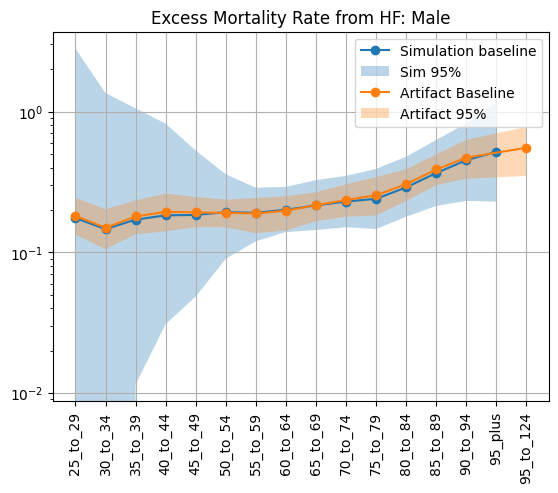

In [96]:
for sex in HF_emr_allyear.sex.unique():
    plt.figure() 
    subdata = HF_emr_allyear.loc[(HF_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_HF.loc[(art_emr_HF.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Looks a little wild in the youngest age groups but I think this is likely just due to very small sample sizes 

When I changed it to the median it matches exactly